In [1]:
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt

In [2]:
CUTOFF = 10
FS = 50
ORDER = 1

In [3]:
with open("imputed_sensor_data.pkl", "rb") as f:
    sensor_data = pickle.load(f)

In [4]:
def apply_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype="low", analog=False)
    y = filtfilt(b, a, data)
    return y

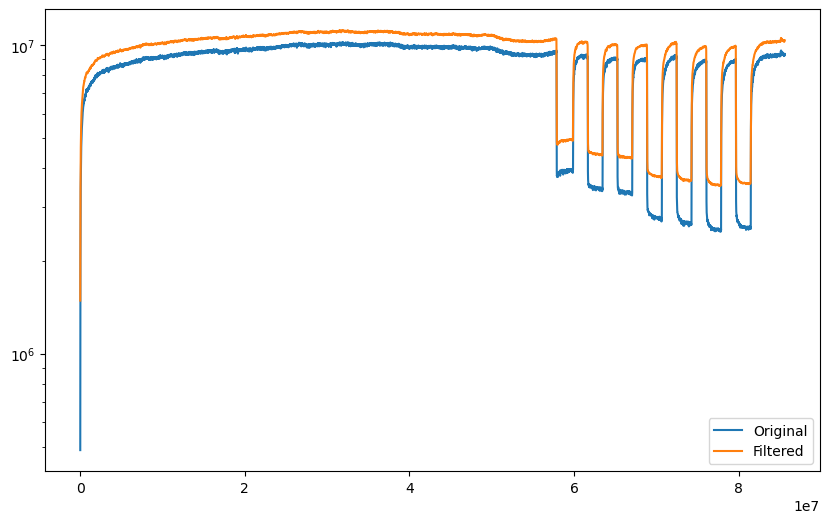

In [5]:
heater = sensor_data["mat_0"][0][0]
gas_data = heater["Resistance Gassensor"].values
filtered_data = apply_lowpass_filter(gas_data, CUTOFF, FS, ORDER)
time = heater["Time Since PowerOn"].values

plt.figure(figsize=(10, 6))
plt.plot(time, gas_data, label="Original")
plt.plot(time, (filtered_data + 1e6), label="Filtered")
plt.yscale("log")
plt.legend()
plt.show()

In [6]:
for mat in range(2):
    for sensor in range(8):
        for heater in range(10):
            heater_data = sensor_data[f"mat_{mat}"][sensor][heater]
            
            unfiltered = heater_data["Resistance Gassensor"]
            filtered = apply_lowpass_filter(unfiltered, CUTOFF, FS, ORDER)
            heater_data["Filtered_Gas"] = filtered

            unfiltered = heater_data["Temperature"]
            filtered = apply_lowpass_filter(unfiltered, CUTOFF, FS, ORDER)
            heater_data["Filtered_Temperature"] = filtered

            unfiltered = heater_data["Pressure"]
            filtered = apply_lowpass_filter(unfiltered, CUTOFF, FS, ORDER)
            heater_data["Filtered_Pressure"] = filtered

            unfiltered = heater_data["Relative Humidity"]
            filtered = apply_lowpass_filter(unfiltered, CUTOFF, FS, ORDER)
            heater_data["Filtered_Relative_Humidity"] = filtered

In [7]:
def plot_filtered_data(sensor_data, mat, sensor, skip=0, include_types=["gas"]):
    title = f"Matrix {mat}, Sensor {sensor}"
    fig = go.Figure()
    for i, data in sensor_data[f"mat_{mat}"][sensor].items():
        if "gas" in include_types:
            fig.add_trace(go.Scatter(x=data["Time Since PowerOn"][skip:],
                                     y=data["Filtered_Gas"][skip:],
                                     mode="lines",
                                     name=f"Gas {i}"))
        if "temp" in include_types:
            fig.add_trace(go.Scatter(x=data["Time Since PowerOn"][skip:],
                                     y=data["Filtered_Temperature"][skip:],
                                     mode="lines",
                                     name=f"Temp {i}"))

        if "rh" in include_types:
            fig.add_trace(go.Scatter(x=data["Time Since PowerOn"][skip:],
                                     y=data["Filtered_Relative_Humidity"][skip:],
                                     mode="lines",
                                     name=f"RH {i}"))

        if "press" in include_types:
            fig.add_trace(go.Scatter(x=data["Time Since PowerOn"][skip:],
                                     y=data["Filtered_Pressure"][skip:],
                                     mode="lines",
                                     name=f"Prs {i}"))

    fig.update_layout(title=title, title_x=0.5, width=1000, height=600)

    fig.update_yaxes(type="log")
    fig.show()

In [10]:
include_types = [
    #"gas",
    "temp",
    "rh",
    #"press"
]
plot_filtered_data(sensor_data, 0, 0, skip=5000,
                   include_types=include_types)

In [11]:
with open("lpf_sensor_data.pkl", "wb") as f:
    pickle.dump(sensor_data, f)